# Individual Fairness

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors
plt.style.use('seaborn')
%matplotlib inline

import numpy as np
import sklearn.metrics as sk_metrics

import pickle

In [2]:
delta = 0  # tolerance (delta) on predictive performance
x_precision = .05  # .05 # .02 # .02 # x-axis plot step space

save_fig = True
folds = range(0, 10)

favourable_classes = set([b'+', b'good', b'>50K'])

# Testcase
task_id, flow_id = 31, 66

# Fairness
## Top-performing pipeline for each data set (i.e., task)
### Supervised Classification on credit-approval # Gradient Boosting
# task_id, flow_id = 29, 12736
### Supervised Classification on credit-g # Ranger Classifier
# task_id, flow_id = 31, 6794
### Supervised Classification on adult # Boosting with Decision Trees
# task_id, flow_id = 7592, 6970

In [3]:
task_flow = {}

with open(f'./run_cache/{task_id}/{task_id}_{flow_id}.pickle', 'br') as f:
    dict_ = pickle.load(f)

    labels = dict_['labels']
    predictions = dict_['runs']

In [4]:
per_fold_metric = dict()
the_good_value = None
the_bad_value = None

for fold_id in folds:
    per_fold_metric[fold_id] = dict()

    one_value = np.unique(labels[fold_id])
    assert one_value.shape[0] == 2
    if one_value[0] in favourable_classes:
        this_value = one_value[0]
        other_value = one_value[1]
    elif one_value[1] in favourable_classes:
        this_value = one_value[1]
        other_value = one_value[0]
    else:
        assert False, f'Could not find favourable class: {one_value}'

    if the_good_value is None:
        the_good_value = this_value
    else:
        assert the_good_value == this_value
    if the_bad_value is None:
        the_bad_value = other_value
    else:
        assert the_bad_value == other_value

    for y_ in predictions[flow_id][fold_id]:
        y = labels[fold_id].astype(y_.dtype)

        # get performance
        y_acc = sk_metrics.accuracy_score(y, y_)
        if delta:
            y_acc = np.around(y_acc, decimals=delta)
        
        if y_acc in per_fold_metric[fold_id]:
            per_fold_metric[fold_id][y_acc].append(y_)
        else:
            per_fold_metric[fold_id][y_acc] = [y_]

In [5]:
best_model = dict()
best_model_plot = []
majority_class = []
class_ballance = []

for fold_id in folds:
    best_model[fold_id] = {}
    plot_x = []
    plot_y = []
    for acc, y_ in per_fold_metric[fold_id].items():
        y_array_ = np.asarray(y_)
        y = labels[fold_id].astype(y_array_.dtype)

        # get most desirable predictions
        y_best = np.full(y.shape, the_bad_value, dtype=y.dtype)
        best_ind = (y_array_ == the_good_value).any(axis=0)
        y_best[best_ind] = the_good_value

        best_acc = sk_metrics.accuracy_score(y, y_best)

        best_model[fold_id][acc] = best_acc
        plot_x.append(acc)
        plot_y.append(best_acc)

    best_model_plot.append((plot_x, plot_y))
    majority_class.append(sk_metrics.accuracy_score(
        y,
        np.full(y.shape, the_good_value, dtype=y.dtype)))
    class_ballance.append(np.unique(y, return_counts=True))

In [6]:
# colours = plt.rcParams['axes.prop_cycle'].by_key()['color']

cc = plt.get_cmap('tab10')  # Set3
colours = [plt_colors.rgb2hex(cc(i)) for i in range(cc.N)]

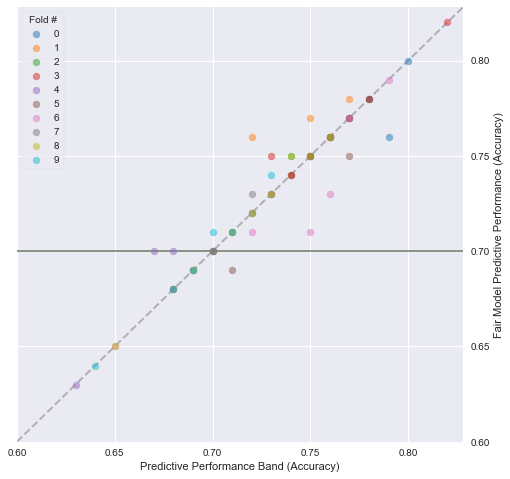

In [7]:
f = plt.figure(figsize=(8, 8))

x_range = set()
y_range = set()
for (x, y), fold_id, c in zip(best_model_plot, folds, colours):
    x_range = x_range.union(x)
    y_range = y_range.union(y)
    plt.scatter(x, y, color=c, label=fold_id, zorder=3, alpha=.5)

total_range = x_range.union(y_range)
total_min, total_max = min(total_range), max(total_range)
total_min = total_min - 0.01*total_min
total_max = total_max + 0.01*total_max
# total_min, total_max = .4, 1.
# total_min, total_max = .48, .88
# total_max = .9 + (.7-min_)
# total_min, total_max = 0.67, .93
plt.xlim((total_min, total_max))
plt.ylim((total_min, total_max))

if x_precision:
    x_range_min = np.around(min(x_range), decimals=1)
    x_range_max = np.around(max(x_range), decimals=1)  # 1.01 # default
    # x_range_min = .45
    # x_range_max = .87
    # x_range_min, x_range_max = .68, .93
    plt.xticks(
        np.arange(x_range_min, x_range_max, x_precision)
    )
    plt.yticks(
        np.arange(x_range_min, x_range_max, x_precision)
    )

min_, max_ = min(total_min, x_range_min), max(total_max, x_range_max)
plt.plot((min_, max_), (min_, max_), color='black', alpha=.25, lw=2, zorder=1, linestyle='--')

for majority, c in zip(majority_class, colours):
    plt.hlines(majority, min_, max_, color=c, zorder=2, alpha=.25)

# f.axes[0].invert_xaxis()

plt.xlabel('Predictive Performance Band (Accuracy)')
plt.ylabel('Fair Model Predictive Performance (Accuracy)')
f.axes[0].yaxis.tick_right()
f.axes[0].yaxis.set_label_position('right')

plt.legend(title='Fold #', loc='upper left', frameon=True, framealpha=.75)  # , facecolor='white'

if save_fig:
    plt.savefig(
        f'../figure/fair_model_{task_id}_{flow_id}_{delta}.pdf',
        dpi=300,
        bbox_inches='tight',
        pad_inches=0)

In [8]:
for fold_id, (types, ballance) in enumerate(class_ballance):
    total = ballance.sum()
    print(f'Ballance of fold #{fold_id}: '
          f'({types[0]}) {ballance[0]/total:.2f}  vs.  '
          f'({types[1]}) {ballance[1]/total:.2f}')

Ballance of fold #0: (b'bad') 0.30  vs.  (b'good') 0.70
Ballance of fold #1: (b'bad') 0.30  vs.  (b'good') 0.70
Ballance of fold #2: (b'bad') 0.30  vs.  (b'good') 0.70
Ballance of fold #3: (b'bad') 0.30  vs.  (b'good') 0.70
Ballance of fold #4: (b'bad') 0.30  vs.  (b'good') 0.70
Ballance of fold #5: (b'bad') 0.30  vs.  (b'good') 0.70
Ballance of fold #6: (b'bad') 0.30  vs.  (b'good') 0.70
Ballance of fold #7: (b'bad') 0.30  vs.  (b'good') 0.70
Ballance of fold #8: (b'bad') 0.30  vs.  (b'good') 0.70
Ballance of fold #9: (b'bad') 0.30  vs.  (b'good') 0.70
